In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random

import sys
sys.path.append("..")  # Add parent directory to sys.path

from data.dataset import OcclusionRemovalDataset

In [2]:
train_data_path = '/Path/To/Base/Train/Directory/'
test_data_path  = '/Path/To/Base/Test/Directory/'

## Importing data

In [4]:
derivative_slope_dataset      = OcclusionRemovalDataset(data_dir=test_data_path, labeling_method='derivative_slope'     )
integral_ratio_dataset        = OcclusionRemovalDataset(data_dir=test_data_path, labeling_method='integral_ratio'       )
symmetric_sampling_dataset    = OcclusionRemovalDataset(data_dir=test_data_path, labeling_method='symmetric_sampling'   )
estimation_correction_dataset = OcclusionRemovalDataset(data_dir=test_data_path, labeling_method='estimation_correction')

Loading data..: 100%|██████████| 200/200 [00:34<00:00,  5.87it/s]


In [5]:
print(f'Dev Slope number of samples:     {len(derivative_slope_dataset)     }')
print(f'Integ Ratio number of samples:   {len(integral_ratio_dataset)       }')
print(f'Sym Sampling number of samples:  {len(symmetric_sampling_dataset)   }')
print(f'Estim Correct number of samples: {len(estimation_correction_dataset)}')

Dev Slope number of samples:     35988
Integ Ratio number of samples:   35988
Sym Sampling number of samples:  35988
Estim Correct number of samples: 35988


## Retriving Dataframes

In [5]:
def get_dataframes(derivative_slope_dataset, integral_ratio_dataset,
                   symmetric_sampling_dataset, estimation_correction_dataset,
                   folder_name):
     
     def dataset_details(dataset):
          # Initialize folders dictionary
          details = {}
          # Iterate through samples
          for idx, name in enumerate(dataset.names):
               # Check if this is the first time finding this folder
               if name not in details.keys():
                    details[name] = {'idxs':[], 'positions': [],
                                     'horizontal_labels':[],'vertical_labels':[] }
               # Append the index of the sample to this folder name
               details[name]['idxs'].append(idx)
               details[name]['positions'].append(dataset.positions[idx])
               details[name]['horizontal_labels'].append(dataset.horizontal_labels[idx])
               details[name]['vertical_labels'].append(dataset.vertical_labels[idx])

          return details


     folder_dir = os.path.join(derivative_slope_dataset.data_dir, folder_name)

     # Read the corresponding verification file
     csv_path = os.path.join(folder_dir, f'{folder_name}_verification_scores.csv')
     scores = pd.read_csv(csv_path, index_col=0)

     # Initialaize dataframes
     images_df                = pd.DataFrame(index=scores.index, columns=scores.columns)
     heatmap_df               = scores.copy()
     derivative_slope_df      = pd.DataFrame(index=scores.index, columns=scores.columns)
     integral_ratio_df        = pd.DataFrame(index=scores.index, columns=scores.columns)
     symmetric_sampling_df    = pd.DataFrame(index=scores.index, columns=scores.columns)
     estimation_correction_df = pd.DataFrame(index=scores.index, columns=scores.columns)


     derivative_slope_details      = dataset_details(derivative_slope_dataset)
     integral_ratio_details        = dataset_details(integral_ratio_dataset)
     symmetric_sampling_details    = dataset_details(symmetric_sampling_dataset)
     estimation_correction_details = dataset_details(estimation_correction_dataset)

     # Collect the samples
     for row in list(scores.index):
            for column in list(scores.columns):
               # images
               image_path = os.path.join(folder_dir, f'{folder_name}_{row}_{column}.jpg')
               if os.path.exists(image_path):
                    images_df.loc[row, column] = image_path

               # derivative_slope
               for idx, position in enumerate(derivative_slope_details[folder_name]['positions']):
                     if position == f'{row}_{column}':
                         derivative_slope_df.loc[row, column] = [derivative_slope_details[folder_name]['horizontal_labels'][idx],
                                                                 derivative_slope_details[folder_name]['vertical_labels'][idx]]
               # integral_ratio
               for idx, position in enumerate(integral_ratio_details[folder_name]['positions']):
                     if position == f'{row}_{column}':
                         integral_ratio_df.loc[row, column] = [integral_ratio_details[folder_name]['horizontal_labels'][idx],
                                                               integral_ratio_details[folder_name]['vertical_labels'][idx]]
               
               # symmetric_sampling
               for idx, position in enumerate(symmetric_sampling_details[folder_name]['positions']):
                    if position == f'{row}_{column}':
                         symmetric_sampling_df.loc[row, column] = [symmetric_sampling_details[folder_name]['horizontal_labels'][idx],
                                                                   symmetric_sampling_details[folder_name]['vertical_labels'][idx]]
               
               # estimation_correction
               for idx, position in enumerate(estimation_correction_details[folder_name]['positions']):
                    if position == f'{row}_{column}':
                         estimation_correction_df.loc[row, column] = [estimation_correction_details[folder_name]['horizontal_labels'][idx],
                                                                      estimation_correction_details[folder_name]['vertical_labels'][idx]]
     
     return images_df , heatmap_df , derivative_slope_df, integral_ratio_df, symmetric_sampling_df, estimation_correction_df
        

## Plotting functions

In [6]:
def isValidLabel(label):
    result = True

    if label is None:
        result = False
    
    if not isinstance(label, list):
        if np.isnan(label):
            result = False

    return result

### Plot Images

In [7]:
def plot_images_grid(images_df, folder_name):
    paths_frame = []

    # Iterate throught dataframe cells
    for row_idx, row in enumerate(list(images_df.index)):
        # Append one new list for every row
        paths_frame.append([])
        for column in list(images_df.columns):
            image_path = images_df.loc[row, column]
            try:
                # If the image exists append her path to this spot
                if os.path.exists(image_path):
                    paths_frame[row_idx].append(image_path)
                # If the image does not exist append an empty string
                else:
                    paths_frame[row_idx].append('')
            except:
                paths_frame[row_idx].append('')
                
    # Define the number of rows and columns in your grid.
    num_rows = len(paths_frame)
    num_cols = len(paths_frame[0])

    # Calculate the total figure size to remove spacing between subplots
    fig_width  = num_cols * 5  # Adjust the size as needed
    fig_height = num_rows * 5  # Adjust the size as needed

    # Set the size of the figure
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    for i in range(num_rows):
        for j in range(num_cols):
            ax = fig.add_subplot(num_rows, num_cols, i * num_cols + j + 1)
            if paths_frame[i][j]:
                img = mpimg.imread(paths_frame[i][j])
                ax.imshow(img)
            else:
                # Create a blank white image for positions with no path
                blank_image = np.ones((100, 100, 3), dtype=np.uint8) * 255
                ax.imshow(blank_image)
                
            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis("off")  # Turn off axis labels and ticks

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')

    # Save the figure to a file
    folder_dir = f'sanity_check_grid_data/{folder_name}'
    # Check if the folder exists
    if not os.path.exists(folder_dir):
        # If it doesn't exist, create it
        os.makedirs(folder_dir)

    save_path = os.path.join(folder_dir, 'images_grid.png')
    fig.savefig(save_path, bbox_inches='tight')
    
    plt.close()

    return fig, save_path

### Plot heatmap

In [105]:
def plot_heatmap(heatmap_df, folder_name):

    # Create a heatmap
    border_width = 3
    n_rows, n_cols = heatmap_df.shape


    fig = plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
    ax = sns.heatmap(heatmap_df,
                annot=True, 
                cmap='RdYlGn',
                linewidths=.5,
                fmt=".1f") # Adjust cmap and other parameters as needed
    # Define the fill color with transparency (RGBA format)
    fill_color = (0, 0, 0, 0.5)  # (R, G, B, Alpha)
    # Define the upper block
    ax.add_patch(plt.Rectangle(xy=(0,  0),
                               width=n_cols, height=border_width,
                               fill=True, color=fill_color, lw=0))
    # Define the lower block
    ax.add_patch(plt.Rectangle(xy=(0, n_rows-border_width),
                               width=n_cols, height=n_rows,
                               fill=True, color=fill_color, lw=0))
    # Define the left block
    ax.add_patch(plt.Rectangle(xy=(0,  border_width), 
                               width=border_width, height=n_rows-2*border_width,
                               fill=True, color=fill_color, lw=0))
    # Define th right block
    ax.add_patch(plt.Rectangle(xy=(n_cols-border_width, border_width),
                               width=n_cols, height=n_rows-2*border_width,
                               fill=True, color=fill_color, lw=0))
    # Define the center area border
    ax.add_patch(plt.Rectangle(xy=(border_width,  border_width),
                               width=n_cols-2*border_width, height=n_rows-2*border_width,
                               fill=False, edgecolor="black", lw=3))
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')

    # Save the figure to a file
    folder_dir = f'sanity_check_grid_data/{folder_name}'
    # Check if the folder exists
    if not os.path.exists(folder_dir):
        # If it doesn't exist, create it
        os.makedirs(folder_dir)

    save_path = os.path.join(folder_dir, 'heatmap_grid.png')
    fig.savefig(save_path, bbox_inches='tight')

    plt.close()

    return fig, save_path

### Plot Derivative Slope

In [9]:
def plot_derivative_slope(derivative_slope_df, folder_name):
    arrows = {"LC":(-1,0), "RC":(1,0),"CU":(0, 1),"CD":( 0,-1),
              "LU":(-1,1), "RU":(1,1),"RD":(1,-1),"LD":(-1,-1),
              "CC":None}
    scale = 0.25

    derivative_slope_array = []

    # Iterate throught dataframe cells
    for row_idx, row in enumerate(list(derivative_slope_df.index)):
        # Append one new list for every row
        derivative_slope_array.append([])
        for column in list(derivative_slope_df.columns):
            label = derivative_slope_df.loc[row, column]
            # If the image exists append her path to this spot
            if isValidLabel(label):
                # check for horizontal direction
                if label[0] == [1, 0, 0]:
                    arrow_direction = "L"
                elif label[0] == [0, 0, 1]:
                    arrow_direction = "R"
                else:
                    arrow_direction = "C"

                # check for vertical direction
                if label[1] == [1, 0, 0]:
                    arrow_direction += "U"
                elif label[1] == [0, 0, 1]:
                    arrow_direction += "D"
                else:
                    arrow_direction += "C"    
                
                derivative_slope_array[row_idx].append(arrow_direction)
            # If the image does not exist append an empty string
            else:
                derivative_slope_array[row_idx].append('CC')

    # Plot the figure
    fig, ax = plt.subplots(figsize=(6, 6))

    for r, row in enumerate(derivative_slope_array):
        for c, cell in enumerate(row):

            if (cell) and (cell != 'CC'):
                plt.arrow(c, 5-r, scale * arrows[cell][0], scale * arrows[cell][1], head_width=0.3)
            else:
                # If cell is None, plot a dot
                plt.scatter(c, 5-r, c='black', s=10)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')

    # Save the figure to a file
    folder_dir = f'sanity_check_grid_data/{folder_name}'
    # Check if the folder exists
    if not os.path.exists(folder_dir):
        # If it doesn't exist, create it
        os.makedirs(folder_dir)

    save_path = os.path.join(folder_dir, 'derivative_slope_grid.png')
    fig.savefig(save_path, bbox_inches='tight')

    plt.close()

    return fig, save_path

### Plot integral ratio

In [10]:
def plot_integral_ratio(integral_ratio_df, folder_name):
    arrows = {"LC":(-1,0), "RC":(1,0),"CU":(0, 1),"CD":( 0,-1),
              "LU":(-1,1), "RU":(1,1),"RD":(1,-1),"LD":(-1,-1),
              "CC":None}
    scale = 0.25

    derivative_slope_array = []

    # Iterate throught dataframe cells
    for row_idx, row in enumerate(list(integral_ratio_df.index)):
        # Append one new list for every row
        derivative_slope_array.append([])
        for column in list(integral_ratio_df.columns):
            label = integral_ratio_df.loc[row, column]
            # If the image exists append her path to this spot
            if isValidLabel(label):
                
                # check for horizontal direction
                if label[0] == [1, 0, 0]:
                    arrow_direction = "L"
                elif label[0] == [0, 0, 1]:
                    arrow_direction = "R"
                else:
                    arrow_direction = "C"

                # check for vertical direction
                if label[1] == [1, 0, 0]:
                    arrow_direction += "U"
                elif label[1] == [0, 0, 1]:
                    arrow_direction += "D"
                else:
                    arrow_direction += "C"
                    
                derivative_slope_array[row_idx].append(arrow_direction)
            # If the image does not exist append an empty string
            else:
                derivative_slope_array[row_idx].append('CC')

    # Plot the figure
    fig, ax = plt.subplots(figsize=(6, 6))

    for r, row in enumerate(derivative_slope_array):
        for c, cell in enumerate(row):
            if (cell) and (cell != 'CC'):
                plt.arrow(c, 5-r, scale * arrows[cell][0], scale * arrows[cell][1], head_width=0.3)
            else:
                # If cell is None, plot a dot
                plt.scatter(c, 5-r, c='black', s=10)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')
    
    # Save the figure to a file
    folder_dir = f'sanity_check_grid_data/{folder_name}'
    # Check if the folder exists
    if not os.path.exists(folder_dir):
        # If it doesn't exist, create it
        os.makedirs(folder_dir)

    save_path = os.path.join(folder_dir, 'integral_ratio_grid.png')
    fig.savefig(save_path, bbox_inches='tight')

    plt.close()

    return fig, save_path

### PLot symetric sampling

In [11]:
def propabilites_similarity(prob1, prob2):


    if (prob1 == 0.0 )and (prob2 == 0.0):
        similarity = 1

    else:
        # Compute the relative distance of those two values
        r_value = float(abs(prob1 - prob2)/(prob1 + prob2))

        # Compute the similarity:
        # 0: no similarity
        # 1: maximum similarity
        similarity = 1 -r_value

    return similarity

def plot_symmetric_sampling(symmetric_sampling_df, folder_name):
    arrows = {"LC":(-1,0), "RC":(1,0),"CU":(0, 1),"CD":( 0,-1),
              "LU":(-1,1), "RU":(1,1),"RD":(1,-1),"LD":(-1,-1),
              "CC":None}
    scale = 0.25

    derivative_slope_array = []

    # Iterate throught dataframe cells
    for row_idx, row in enumerate(list(symmetric_sampling_df.index)):
        # Append one new list for every row
        derivative_slope_array.append([])
        for column in list(symmetric_sampling_df.columns):
            label = symmetric_sampling_df.loc[row, column]
            # If the image exists append her path to this spot
            if isValidLabel(label):
                
                # check for horizontal direction
                try:
                    similar = propabilites_similarity(label[0][0], label[0][1])

                    if similar > 0.99:
                         arrow_direction = "C"
                    elif label[0][0] > label[0][1]:
                        arrow_direction = "L"
                    elif label[0][0] < label[0][1]:
                        arrow_direction = "R"
                    else:
                        arrow_direction = "C"
                except:
                    arrow_direction = "C"

                # check for vertical direction
                try:
                    similar = propabilites_similarity(label[1][0], label[1][1])

                    if similar > 0.99:
                         arrow_direction += "C"
                    elif label[1][0] > label[1][1]:
                        arrow_direction += "U"
                    elif label[1][0] < label[1][1]:
                        arrow_direction += "D"
                    else:
                        arrow_direction += "C"
                except:
                    arrow_direction += "C"
                
                derivative_slope_array[row_idx].append(arrow_direction)
            # If the image does not exist append an empty string
            else:
                derivative_slope_array[row_idx].append('CC')

    # Plot the figure
    fig, ax = plt.subplots(figsize=(6, 6))

    for r, row in enumerate(derivative_slope_array):
        for c, cell in enumerate(row):
            if (cell) and (cell != 'CC'):
                plt.arrow(c, 5-r, scale * arrows[cell][0], scale * arrows[cell][1], head_width=0.3)
            else:
                # If cell is None, plot a dot
                plt.scatter(c, 5-r, c='black', s=10)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')
    
    # Save the figure to a file
    folder_dir = f'sanity_check_grid_data/{folder_name}'
    # Check if the folder exists
    if not os.path.exists(folder_dir):
        # If it doesn't exist, create it
        os.makedirs(folder_dir)

    save_path = os.path.join(folder_dir, 'symetric_sampling_grid.png')
    fig.savefig(save_path, bbox_inches='tight')

    plt.close()

    return fig, save_path

### Plot estimation correction

In [12]:
def propabilites_similarity(prob1, prob2):


    if (prob1 == 0.0 )and (prob2 == 0.0):
        similarity = 1

    else:
        # Compute the relative distance of those two values
        r_value = float(abs(prob1 - prob2)/(prob1 + prob2))

        # Compute the similarity:
        # 0: no similarity
        # 1: maximum similarity
        similarity = 1 -r_value

    return similarity

def plot_estimation_correction(estimation_correction_df, folder_name):
    arrows = {"LC":(-1,0), "RC":(1,0),"CU":(0, 1),"CD":( 0,-1),
              "LU":(-1,1), "RU":(1,1),"RD":(1,-1),"LD":(-1,-1),
              "CC":None}
    scale = 0.25

    derivative_slope_array = []

    # Iterate throught dataframe cells
    for row_idx, row in enumerate(list(estimation_correction_df.index)):
        # Append one new list for every row
        derivative_slope_array.append([])
        for column in list(estimation_correction_df.columns):
            label = estimation_correction_df.loc[row, column]
            # If the image exists append her path to this spot
            if isValidLabel(label):
                # check for horizontal direction
                try:
                    similar = propabilites_similarity(label[0][0], label[0][1])

                    if similar > 0.99:
                        arrow_direction = "C"
                    elif label[0][0] > label[0][1]:
                        arrow_direction = "L"
                    elif label[0][0] < label[0][1]:
                        arrow_direction = "R"
                    else:
                        arrow_direction = "C"
                except:
                    arrow_direction = "C"

                # check for vertical direction
                try:
                    similar = propabilites_similarity(label[1][0], label[1][1])

                    if similar > 0.99:
                        arrow_direction += "C"
                    elif label[1][0] > label[1][1]:
                        arrow_direction += "U"
                    elif label[1][0] < label[1][1]:
                        arrow_direction += "D"
                    else:
                        arrow_direction += "C"
                except:
                    arrow_direction += "C"
                
                derivative_slope_array[row_idx].append(arrow_direction)
            # If the image does not exist append an empty string
            else:
                derivative_slope_array[row_idx].append('CC')

    # Plot the figure
    fig, ax = plt.subplots(figsize=(6, 6))

    for r, row in enumerate(derivative_slope_array):
        for c, cell in enumerate(row):
            if (cell) and (cell != 'CC'):
                plt.arrow(c, 5-r, scale * arrows[cell][0], scale * arrows[cell][1], head_width=0.3)
            else:
                # If cell is None, plot a dot
                plt.scatter(c, 5-r, c='black', s=10)
    
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel('')
    plt.ylabel('')
    plt.axis('off')

    # Save the figure to a file
    folder_dir = f'sanity_check_grid_data/{folder_name}'
    # Check if the folder exists
    if not os.path.exists(folder_dir):
        # If it doesn't exist, create it
        os.makedirs(folder_dir)

    save_path = os.path.join(folder_dir, 'estimation_correction_grid.png')
    fig.savefig(save_path, bbox_inches='tight')

    plt.close()

    return fig, save_path

### Plot all plots together

In [13]:
def plot_one_sample_statistics(folder_name,
                               images_df,
                               heatmap_df,
                               derivative_slope_df,
                               integral_ratio_df,
                               symmetric_sampling_df,
                               estimation_correction_df):
    # Plot all together
    fig = plt.figure(layout="constrained",
                    figsize=(20, 30))  # (width, height)
    subfigs = fig.subfigures(3, 1, wspace=0, hspace=0)

    # Row Inputs
    # Set a title for the axes
    subfigs[0].suptitle("Input Data", fontsize=16)  # Overall title for the subfigure
    axs0 = subfigs[0].subplots(1,2, width_ratios=[1,1])

    # Plot the images
    _, path_to_img_fig = plot_images_grid(images_df, folder_name)
    img_fig = plt.imread(path_to_img_fig)

    axs0[0].imshow(img_fig)
    axs0[0].set_title(f'Drone Captures')
    axs0[0].set_xticks([])
    axs0[0].set_yticks([])

    # Plot the verification scores
    _, path_to_htmp_fig = plot_heatmap(heatmap_df, folder_name)
    htmp_fig = plt.imread(path_to_htmp_fig)

    axs0[1].imshow(htmp_fig)
    axs0[1].set_title(f'Verification Scores')
    axs0[1].set_xticks([])
    axs0[1].set_yticks([])


    # Hard Labels
    # Set a title for the axes
    subfigs[1].suptitle("Hard Labels", fontsize=16)  # Overall title for the subfigure
    axs1 = subfigs[1].subplots(1,2)

    # Plot the Derivative Slope labels
    _, path_to_dev_slp_fig = plot_derivative_slope(derivative_slope_df, folder_name)
    dev_slp_fig = plt.imread(path_to_dev_slp_fig)

    axs1[0].imshow(dev_slp_fig)
    axs1[0].set_title(f'Derivative Slope')
    axs1[0].set_xticks([])
    axs1[0].set_yticks([])

    # Plot the Integral Ratio labels
    _, path_to_int_rt_fig = plot_integral_ratio(integral_ratio_df, folder_name)
    int_rt_fig = plt.imread(path_to_int_rt_fig)

    axs1[1].imshow(int_rt_fig)
    axs1[1].set_title(f'Integral Ratio')
    axs1[1].set_xticks([])
    axs1[1].set_yticks([])


    # Soft Labels
    # Set a title for the axes
    subfigs[2].suptitle("Soft Labels", fontsize=16)  # Overall title for the subfigure
    axs2 = subfigs[2].subplots(1,2)

    # Plot the Symmetric Sampling labels
    _, path_to_sym_sam_fig = plot_symmetric_sampling(symmetric_sampling_df, folder_name)
    sym_sam_fig = plt.imread(path_to_sym_sam_fig)

    axs2[0].imshow(sym_sam_fig)
    axs2[0].set_title(f'Symmetric Sampling')
    axs2[0].set_xticks([])
    axs2[0].set_yticks([])

    # Plot the Estimation Correction labels
    _, path_to_est_cor_fig = plot_estimation_correction(estimation_correction_df, folder_name)
    est_cor_fig = plt.imread(path_to_est_cor_fig)

    axs2[1].imshow(est_cor_fig)
    axs2[1].set_title(f'Estimation Correction')
    axs2[1].set_xticks([])
    axs2[1].set_yticks([])

    plt.subplots_adjust(wspace=0, hspace=0)  # Set wspace and hspace to 0
    plt.show()

## Get One Plot

In [102]:
# Train: 1695605007.558531 1695611704.6862988 1695626680.1533415
# Test:  1695897770.766164 1695906444.5619514 1695909174.5161889
folder_name = '1695938647.6265342' # 1695932696.213338 1695933234.787751 1695925719.6203837 1695933564.9830751 1695934013.0170279
# 1695936303.623184 1695936625.9249609 1695935336.2544198 1695935552.3339574 1695935768.7384627 1695935876.2048826 1695935983.0936012

In [103]:
images_df, heatmap_df, \
    derivative_slope_df, integral_ratio_df, \
        symmetric_sampling_df, estimation_correction_df = get_dataframes(derivative_slope_dataset, integral_ratio_dataset,
                                                                         symmetric_sampling_dataset, estimation_correction_dataset,
                                                                         folder_name)

/tmp/ipykernel_122760/490983264.py:84: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0, hspace=0)  # Set wspace and hspace to 0


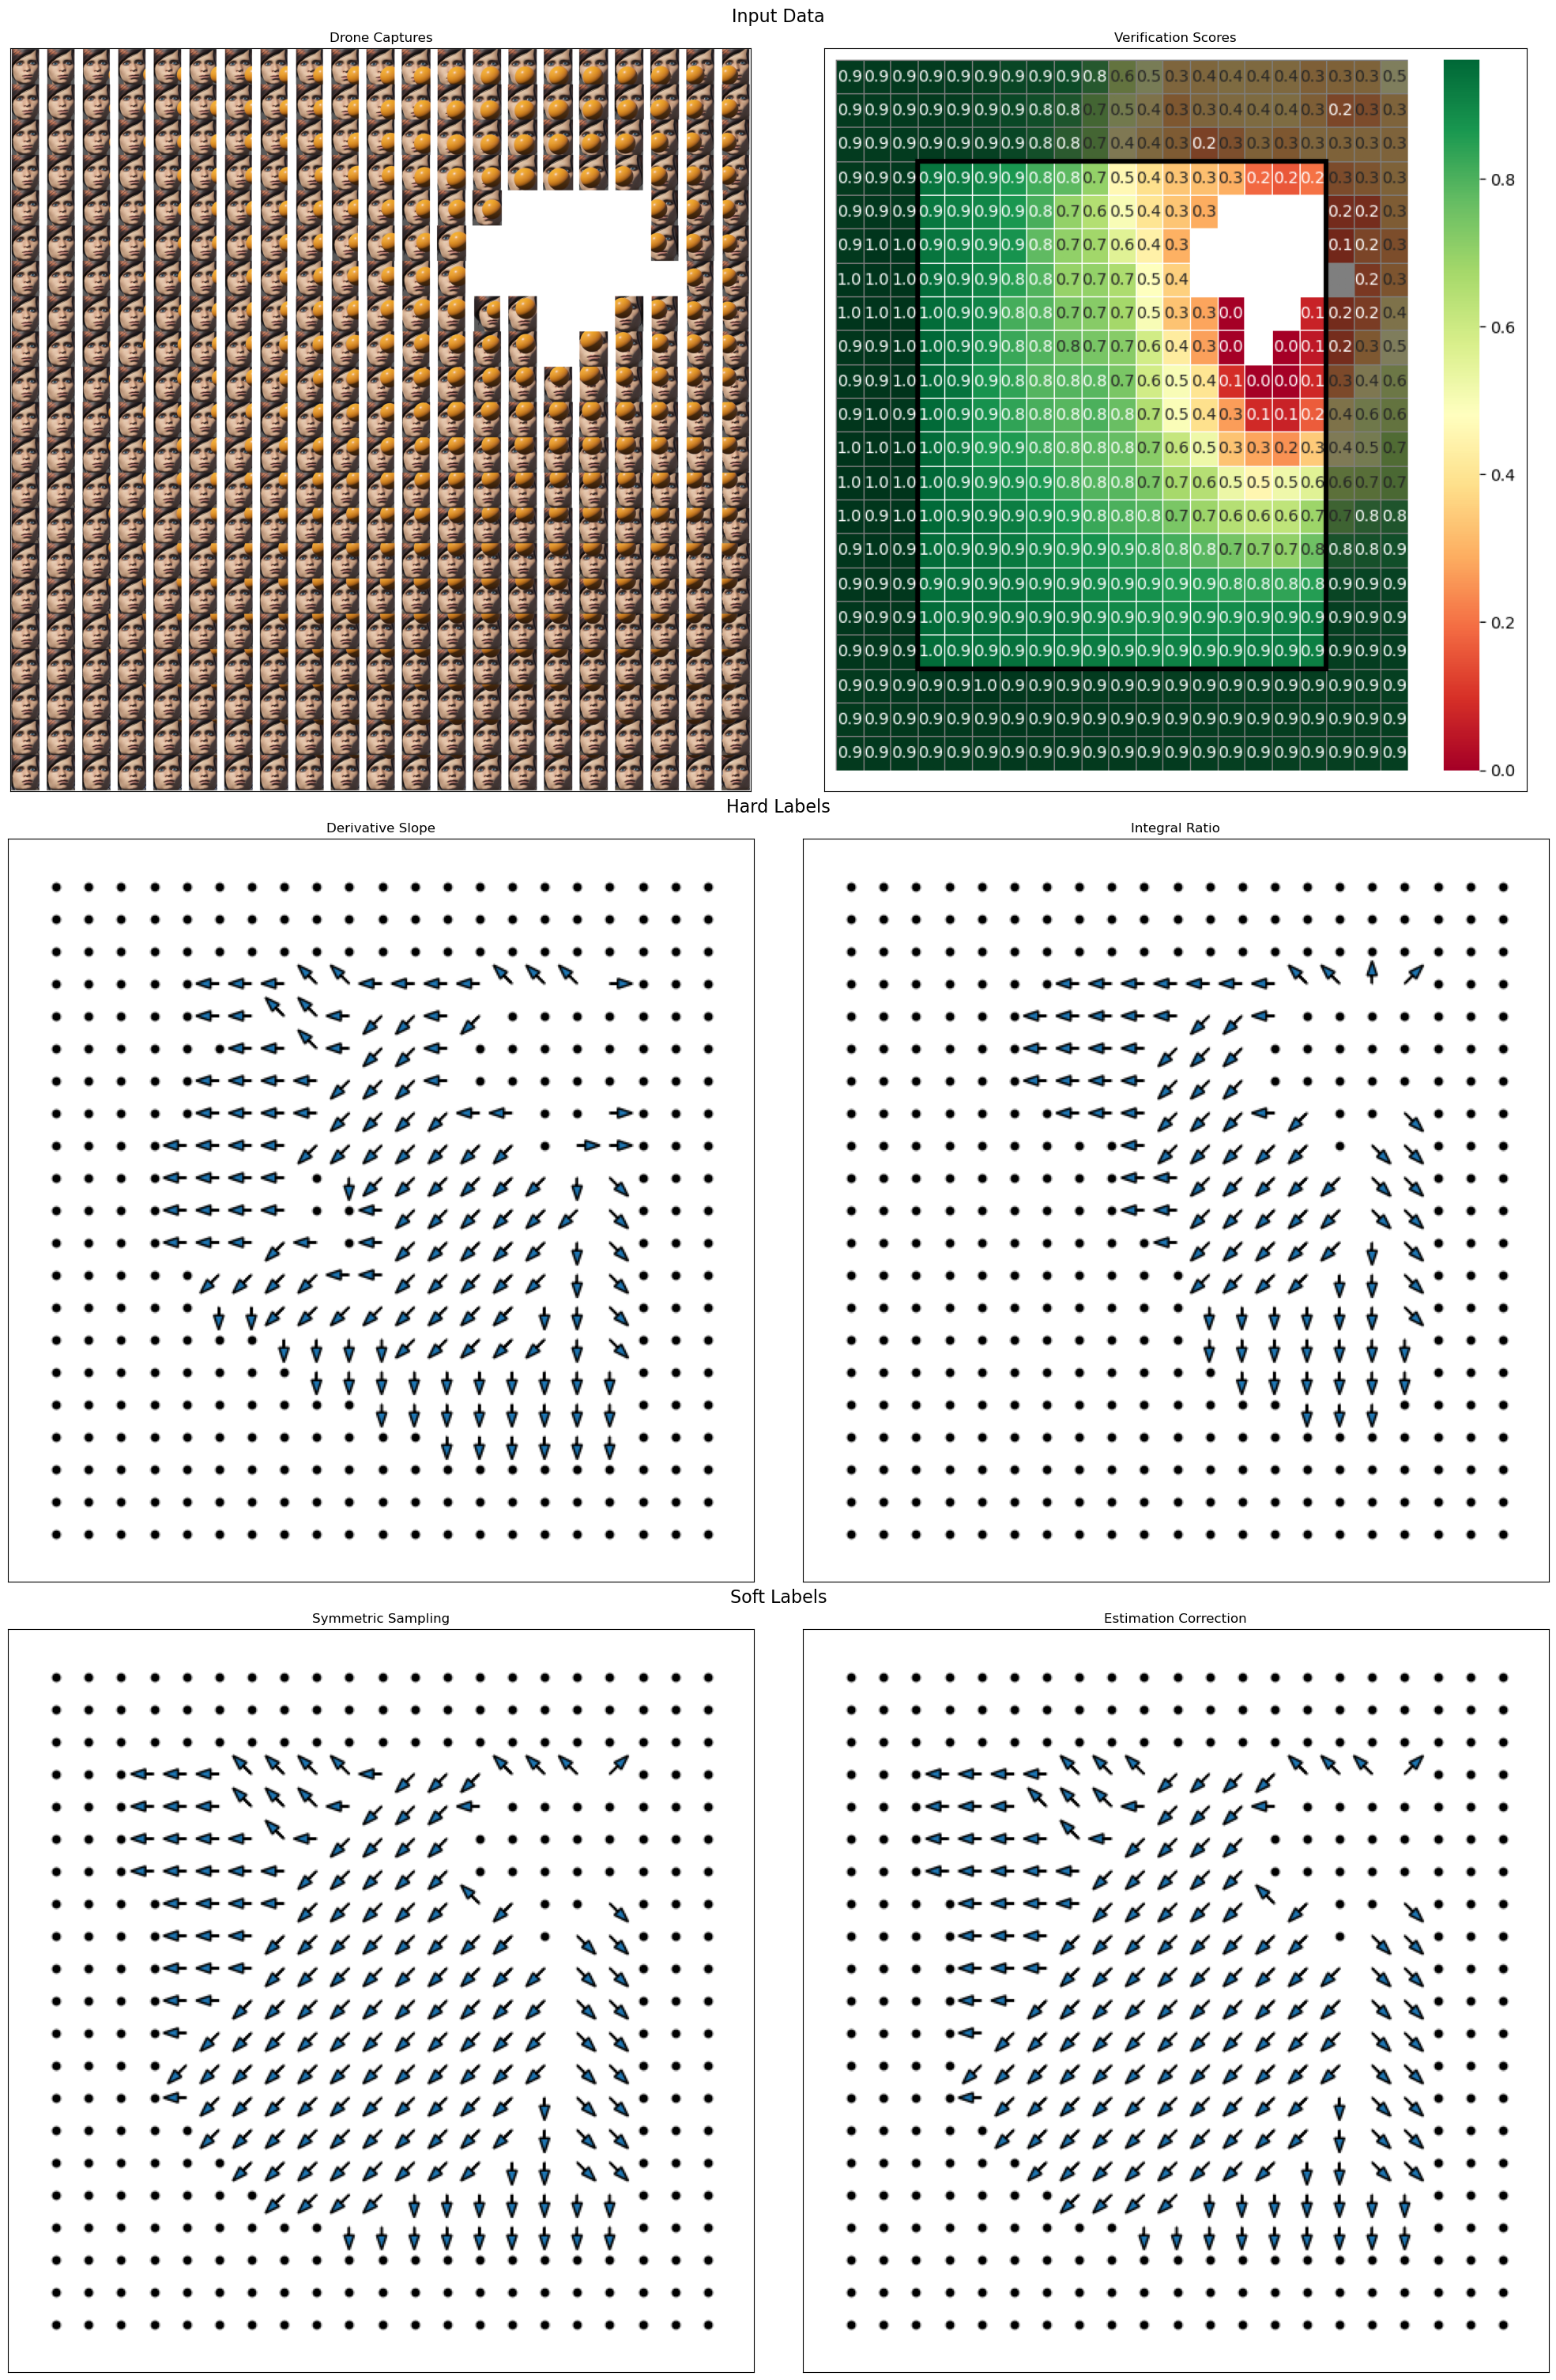

In [106]:
plot_one_sample_statistics(folder_name,
                           images_df,
                           heatmap_df,
                           derivative_slope_df,
                           integral_ratio_df,
                           symmetric_sampling_df,
                           estimation_correction_df)

In [124]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import re
import random

import sys
sys.path.append("..")  # Add parent directory to sys.path

from datasets.Multi_Task_Hard_Labels import OcclusionRemovalDataset_HardLabels
from datasets.Multi_Task_Soft_Labels import OcclusionRemovalDataset_SoftLabels


def clean_list(lst):
    new_lst = []
    for i in lst:
        if i is None:
            new_lst.append(0.0)
        else:
            new_lst.append(i)
    return new_lst

def apply_averaging_window(lst):
    averaged_lst = []
    for i in range(len(lst) - 2):
        window = lst[i:i+3]  # Extract a window of 3 elements
        if None in window:
            averaged_lst.append(0.0)  # Append None if any element in the window is None
        else:
            average = sum(window) / len(window)  # Calculate the average
            averaged_lst.append(average)
    return averaged_lst

def plot_scores_distribution(image_path):
    # Build paths to the selected sample
    parent_path = '/'.join(image_path.split('/')[:-1])
    file_name   = image_path.split('/')[-1]
    # Regular expression to match the desired pattern
    pattern = re.compile(r"(\d+\.\d+)_row:(\d+\.\d+)_col:(\d+\.\d+)")
    # Use regular expression to search for matches
    match = pattern.search(file_name)

    # Extract the numbers
    unique_id = match.group(1)
    row_number = match.group(2)
    col_number = match.group(3)
    
    # Print the extracted numbers
    print(f"Unique ID: {unique_id}")
    print(f"Row number: {row_number}")
    print(f"Col number: {col_number}")

    csv_path  = os.path.join(parent_path, f'{unique_id}_verification_scores.csv')

    print(f"CSV path: {csv_path}")

    # Read csv file
    data = pd.read_csv(csv_path, index_col=0)
    
    # Construct lists
    horizontal_scores = data.loc[f'row:{row_number}']
    vertical_scores   = data[f'col:{col_number}']

    # Clean and avg the lists
    ver_list         = clean_list(vertical_scores)
    ver_list_avg     = apply_averaging_window(ver_list)
    ver_list_dev     = np.gradient(ver_list_avg)
    ver_list_dev_dev = np.gradient(ver_list_dev)

    hor_list         = clean_list(horizontal_scores)
    hor_list_avg     = apply_averaging_window(hor_list)
    hor_list_dev     = np.gradient(hor_list_avg)
    hor_list_dev_dev = np.gradient(hor_list_dev)

    print('len', len(ver_list))
    print(ver_list)
    # Plotting
    fig = plt.figure(#layout="constrained",
                     figsize=(14, 6))  # (width, height)
    subfigs = fig.subfigures(1, 3, wspace=0.07, width_ratios=[1., 2., 2.])
    subfigs[1].subplots_adjust(hspace=0.7)
    subfigs[2].subplots_adjust(hspace=0.7)

    # Image Cells
    axs0 = subfigs[0].subplots(1,1) # (rows, columns)

    # Read and plot the image
    # Load the image
    image = np.asarray(Image.open(image_path))

    # Plot the RGB image
    axs0.imshow(image)
    axs0.set_title('Drone Image')
    axs0.set_xticks([])
    axs0.set_yticks([])

    # Horizontal values
    axs1 = subfigs[1].subplots(2, 1) # (rows, columns)
    axs1[0].plot(range(len(hor_list)), hor_list, marker='o', label='raw verification')
    axs1[0].fill_between(range(len(hor_list)), hor_list, color='lightblue')
    axs1[0].plot([num+1 for num in range(len(hor_list_avg))], hor_list_avg, marker='o', color='orange', label='average verification')
    axs1[0].text(0.01, -0.25,   'Left', transform=axs1[0].transAxes, ha='left'  )
    axs1[0].text( 0.5, -0.25, 'Center', transform=axs1[0].transAxes, ha='center')
    axs1[0].text(0.99, -0.25,  'Right', transform=axs1[0].transAxes, ha='right' )
    axs1[0].set_ylim(0.0, 1.0)
    axs1[0].set_xlim(0, len(hor_list)-1)
    axs1[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs1[0].grid(True)
    axs1[0].set_ylabel('Verification Score (%)')
    axs1[0].set_title(f'Horizontal Verification Scores')
    axs1[0].legend(loc='lower center')

    axs1[1].plot([num+1 for num in range(len(hor_list_dev))], hor_list_dev, marker='o', color='red', label='gradient')
    axs1[1].axhline(y=0, linestyle='dotted', color='black')
    axs1[1].text(0.01, -0.25,   'Left', transform=axs1[1].transAxes, ha='left'  )
    axs1[1].text( 0.5, -0.25, 'Center', transform=axs1[1].transAxes, ha='center')
    axs1[1].text(0.99, -0.25,  'Right', transform=axs1[1].transAxes, ha='right' )
    axs1[1].set_xlim(0, len(hor_list)-1)
    axs1[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs1[1].grid(True)
    axs1[1].set_ylabel('Gradient')
    axs1[1].set_title(f'Horizontal Gradient Curve')
    # axs1[1].legend()


    # Vertical Values
    axs2 = subfigs[2].subplots(2, 1) # (rows, columns)
    axs2[0].plot(range(len(ver_list)), ver_list, marker='o', label='raw verification')
    axs2[0].fill_between(range(len(ver_list)), ver_list, color='lightblue')
    axs2[0].plot([num+1 for num in range(len(ver_list_avg))], ver_list_avg, marker='o', color='orange', label='average verification')
    axs2[0].text(0.01, -0.25,   'Down', transform=axs2[0].transAxes, ha='left'  )
    axs2[0].text( 0.5, -0.25, 'Center', transform=axs2[0].transAxes, ha='center')
    axs2[0].text(0.99, -0.25,     'Up', transform=axs2[0].transAxes, ha='right' )
    axs2[0].set_ylim(0.0, 1.0)
    axs2[0].set_xlim(0, len(ver_list)-1)
    axs2[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs2[0].grid(True)
    axs2[0].set_ylabel('Verification Score (%)')
    axs2[0].set_title(f'Vertical Verification Scores')
    axs2[0].legend(loc='lower center')

    axs2[1].plot([num+1 for num in range(len(ver_list_dev))], ver_list_dev, marker='o', color='red', label='gradient')
    axs2[1].axhline(y=0, linestyle='dotted', color='black')
    axs2[1].text(0.01, -0.25,   'Down', transform=axs2[1].transAxes, ha='left'  )
    axs2[1].text( 0.5, -0.25, 'Center', transform=axs2[1].transAxes, ha='center')
    axs2[1].text(0.99, -0.25,     'Up', transform=axs2[1].transAxes, ha='right' )
    axs2[1].set_xlim(0, len(ver_list)-1)
    axs2[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axs2[1].grid(True)
    axs2[1].set_ylabel('Gradient')
    axs2[1].set_title(f'Vertical Gradient Curve')
    # axs2[1].legend()

    plt.show()

Unique ID: 1695926043.2647777
Row number: 0.00
Col number: 0.10
CSV path: /media/mloufakis/Data/Datasets/Thesis_Datasets/grid_simulation_train_samples/1695926043.2647777/1695926043.2647777_verification_scores.csv
len 21
[0.644967901561907, 0.6356537708869348, 0.6105528070859099, 0.6108039187998907, 0.635191846955643, 0.6110080707411052, 0.5810501005968102, 0.5957879885005566, 0.5581484999251269, 0.5709949176803775, 0.5710700629693777, 0.5423301511447922, 0.5123680786565248, 0.5352177967426748, 0.5603717773066841, 0.5781797629136306, 0.5164030476620323, 0.5248827374415842, 0.6018741536236968, 0.7515025167812703, 0.7610260359188806]


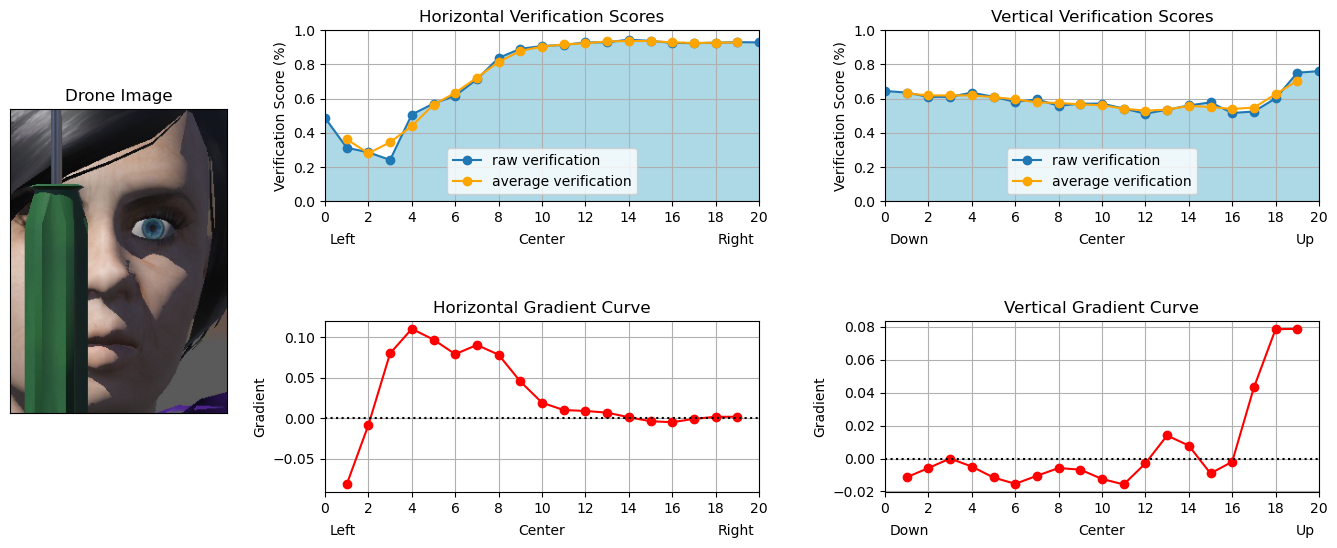

In [125]:
image_path = '/media/mloufakis/Data/Datasets/Thesis_Datasets/grid_simulation_train_samples/1695926043.2647777/1695926043.2647777_row:0.00_col:0.10.jpg'
plot_scores_distribution(image_path)

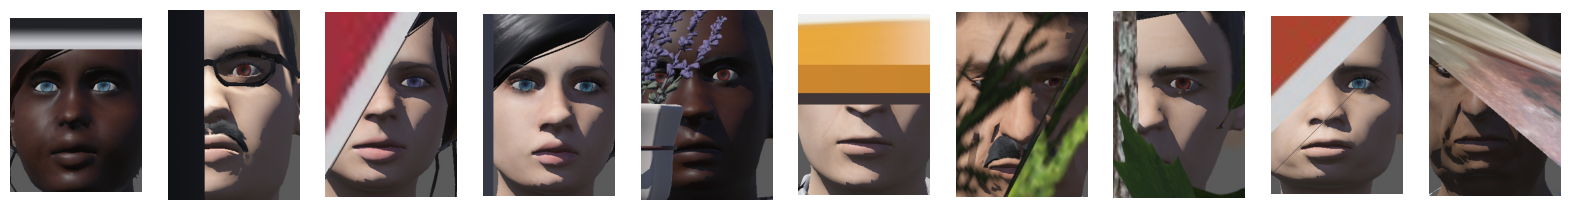

In [414]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot_sample_images(directory):
    # List all non-empty folders
    folders = [os.path.join(directory, f) for f in os.listdir(directory) 
               if os.path.isdir(os.path.join(directory, f)) and os.listdir(os.path.join(directory, f))]
    
    # Sample 20 folders
    sampled_folders = random.sample(folders, min(len(folders), 10))

    # Set up the plot
    fig, axes = plt.subplots(1, len(sampled_folders), figsize=(20, 4))

    for ax, folder in zip(axes, sampled_folders):
        folder_name = folder.split('/')[-1]

        # Construct image path
        image_path = os.path.join(folder, f'{folder_name}_0.jpg')  # Change '.jpg' to the correct format if different

        # Load and plot the image
        try:
            img = Image.open(image_path)
            ax.imshow(img)
            ax.axis('off')
        except FileNotFoundError:
            ax.imshow(np.zeros((100, 100, 3), dtype=np.uint8))  # Show an empty image if the file is not found
            ax.axis('off')
    
    plt.show()


# Example usage

plot_sample_images('/Path/To/Datasets/From/Witch/To/Collect/Samples/')  # Replace with your directory path

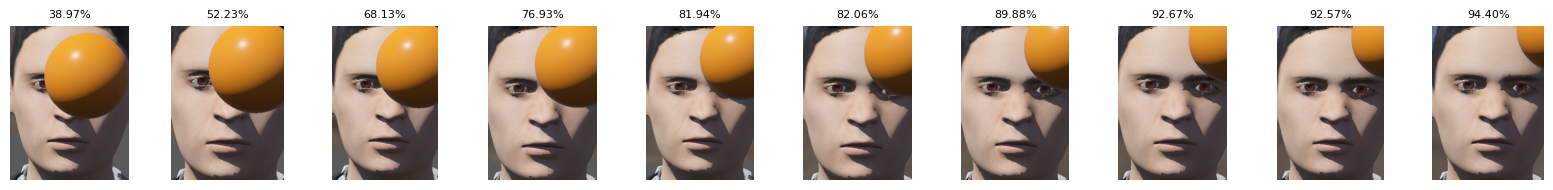

In [333]:
import os
import random
import json
from PIL import Image
import matplotlib.pyplot as plt

def plot_images_with_scores(directory):
    # Get all folders
    folders = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

    # Randomly select a folder
    while True:
        folder = random.choice(folders)
        images = [f for f in os.listdir(folder) if f.endswith('.jpg')]  # Assuming images are in .jpg format

        if len(images) == 10:
            break  # Found a folder with exactly 10 images

    # Set up the plot
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))  # Adjust size as needed

    for ax, img_name in zip(axes, images):
        image_path = os.path.join(folder, img_name)
        json_path = os.path.splitext(image_path)[0] + '.json'  # Replace image extension with .json

        # Load and plot the image
        img = Image.open(image_path)
        ax.imshow(img)
        ax.axis('off')

        # Read the certification score from the corresponding JSON file
        if os.path.exists(json_path):
            with open(json_path, 'r') as file:
                data = json.load(file)
                score = data.get('verification_score', 'N/A')
        else:
            score = 'N/A'

        ax.set_title(f'{score*100:.2f}%', fontsize=8)  # Add score as title

    plt.show()

# Example usage
plot_images_with_scores('/Path/To/Datasets/From/Witch/To/Collect/Samples/')  # Replace with your directory path
